# Airline Passenger Satisfaction
## Comparing Linear Regression and PyTorch Models

This notebook explores the factors influencing airline passenger satisfaction. We will build two models to predict passenger satisfaction:

1. **Linear Regression** using scikit-learn.
2. **Neural Network** using PyTorch.

Finally, we'll compare the accuracy of both models to determine which performs better on this dataset.

In [46]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # Enable CUDA optimization
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


## Read data

In [47]:
# Read CSV file, set the first column as index, but then drop it
test_data=pd.read_csv('test.csv',index_col=0)
train_data=pd.read_csv('train.csv',index_col=0)

# Now, if you want to remove that column from the DataFrame:
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

data=pd.concat([test_data,train_data],ignore_index=True)


## 1. Exploration

In [48]:
data.shape

(129880, 24)

We have 24 columns with 129'880 rows. 

In [49]:
data.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [50]:
data.tail()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
129875,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
129876,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
129877,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
129878,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied
129879,62567,Male,Loyal Customer,27,Business travel,Business,1723,1,3,3,...,1,1,1,4,4,3,1,0,0.0,neutral or dissatisfied


Observation:
- We have several columns with visible categorical data like "Customer Type", but also latent categorical data like "Inflight wifi service". 
- "id" has no impact on satisfaction

In [51]:
data.drop('id',axis=1,inplace=True)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    1298

In [53]:
#convert every column except 'Age','Departure Delay in Minutes', 'Arrival Delay in Minutes','Flight Distance'
cols_to_convert = ['Gender', 'Customer Type', 'Type of Travel', 'Class',
       'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 
       'satisfaction']

# Apply category type to selected columns
for col in cols_to_convert:
    data[col] = data[col].astype('category')

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             129880 non-null  category
 1   Customer Type                      129880 non-null  category
 2   Age                                129880 non-null  int64   
 3   Type of Travel                     129880 non-null  category
 4   Class                              129880 non-null  category
 5   Flight Distance                    129880 non-null  int64   
 6   Inflight wifi service              129880 non-null  category
 7   Departure/Arrival time convenient  129880 non-null  category
 8   Ease of Online booking             129880 non-null  category
 9   Gate location                      129880 non-null  category
 10  Food and drink                     129880 non-null  category
 11  Online boarding           

## 2. Data visualisation and characteristics

In [55]:
data.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1190.316392,14.713713,15.091129
std,15.119360,997.452477,38.071126,38.465650
min,7.000000,31.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000
50%,40.000000,844.000000,0.000000,0.000000
75%,51.000000,1744.000000,12.000000,13.000000
max,85.000000,4983.000000,1592.000000,1584.000000


<Axes: xlabel='Flight Distance', ylabel='Count'>

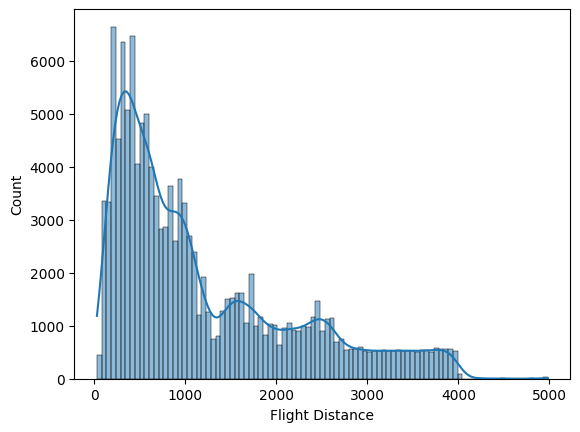

In [56]:
sns.histplot(data['Flight Distance'],kde=True)

<Axes: xlabel='Age', ylabel='Count'>

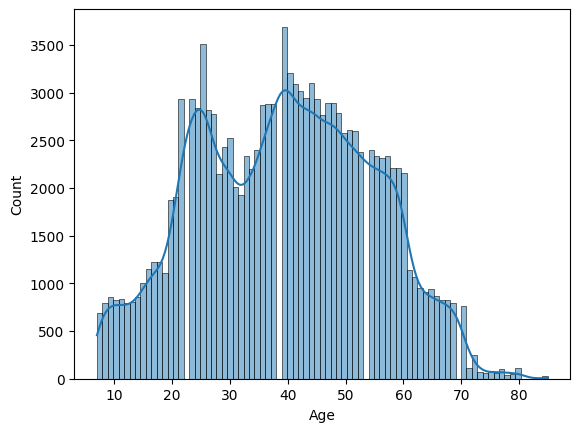

In [57]:
sns.histplot(data['Age'],kde=True)

- most costumers are between 30 and 50 years old

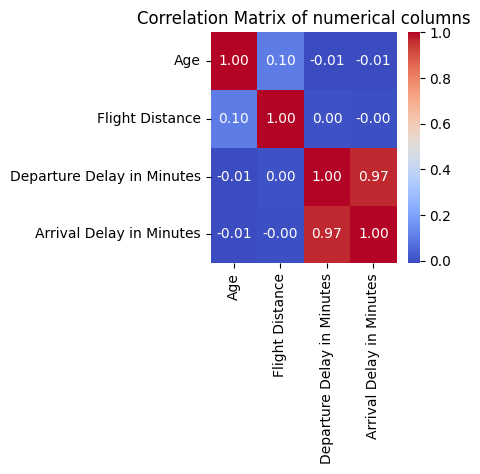

In [58]:
numeric_data = data.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_mat = numeric_data.corr()

plt.figure(figsize=(3, 3))

sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix of numerical columns')

plt.show()

- Departure and Delay are highly correlated, so we will remove at least one of those columns in the future

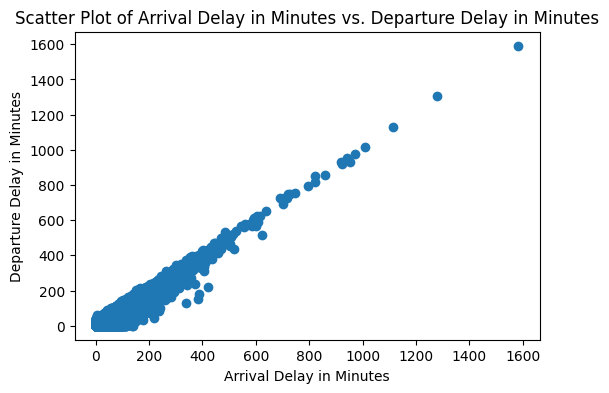

In [59]:

plt.figure(figsize=(6, 4))

plt.scatter(data['Arrival Delay in Minutes'], data['Departure Delay in Minutes'])

plt.xlabel('Arrival Delay in Minutes')

plt.ylabel('Departure Delay in Minutes')

plt.title('Scatter Plot of Arrival Delay in Minutes vs. Departure Delay in Minutes')

plt.show()

- as they have an almost linear relationship, the Arrival Delay is mostly caused by a late departure and not because of occurences during the flight

Now, we will turn to the categorical data

In [60]:
data.describe(include = ['category'])

,Gender,Customer Type,Type of Travel,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
count,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880
unique,2,2,2,3,6,6,6,6,6,6,6,6,6,6,5,6,6,6,2
top,Female,Loyal Customer,Business travel,Business,2,4,3,3,4,4,4,4,4,4,4,4,4,4,neutral or dissatisfied
freq,65899,106100,89693,62160,32320,31880,30393,35717,30563,38468,39756,36791,38703,35886,46761,36333,47323,33969,73452


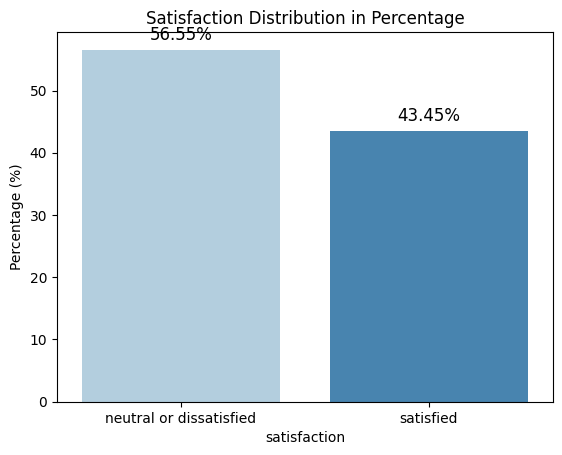

In [61]:
class_percentages = data['satisfaction'].value_counts(normalize=True) * 100

# Plot the percentages using a barplot
sns.barplot(x=class_percentages.index, y=class_percentages.values, palette='Blues')

plt.ylabel('Percentage (%)')

# Display the percentages on top of each bar
for i, v in enumerate(class_percentages.values):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontsize=12)

# Set the title
plt.title('Satisfaction Distribution in Percentage')

# Show the plot
plt.show()

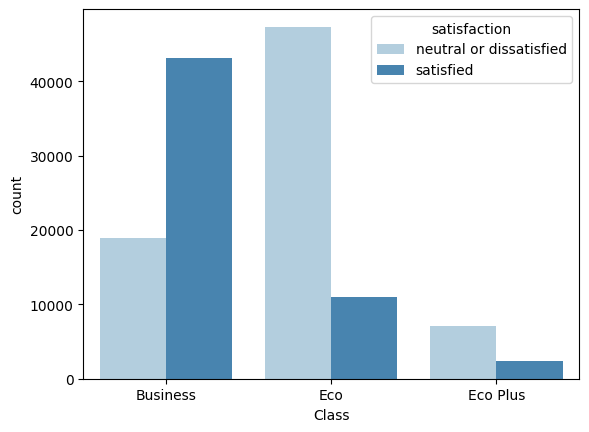

In [62]:
sns.countplot(x = 'Class', hue = 'satisfaction', palette = "Blues", data = data)
plt.show()



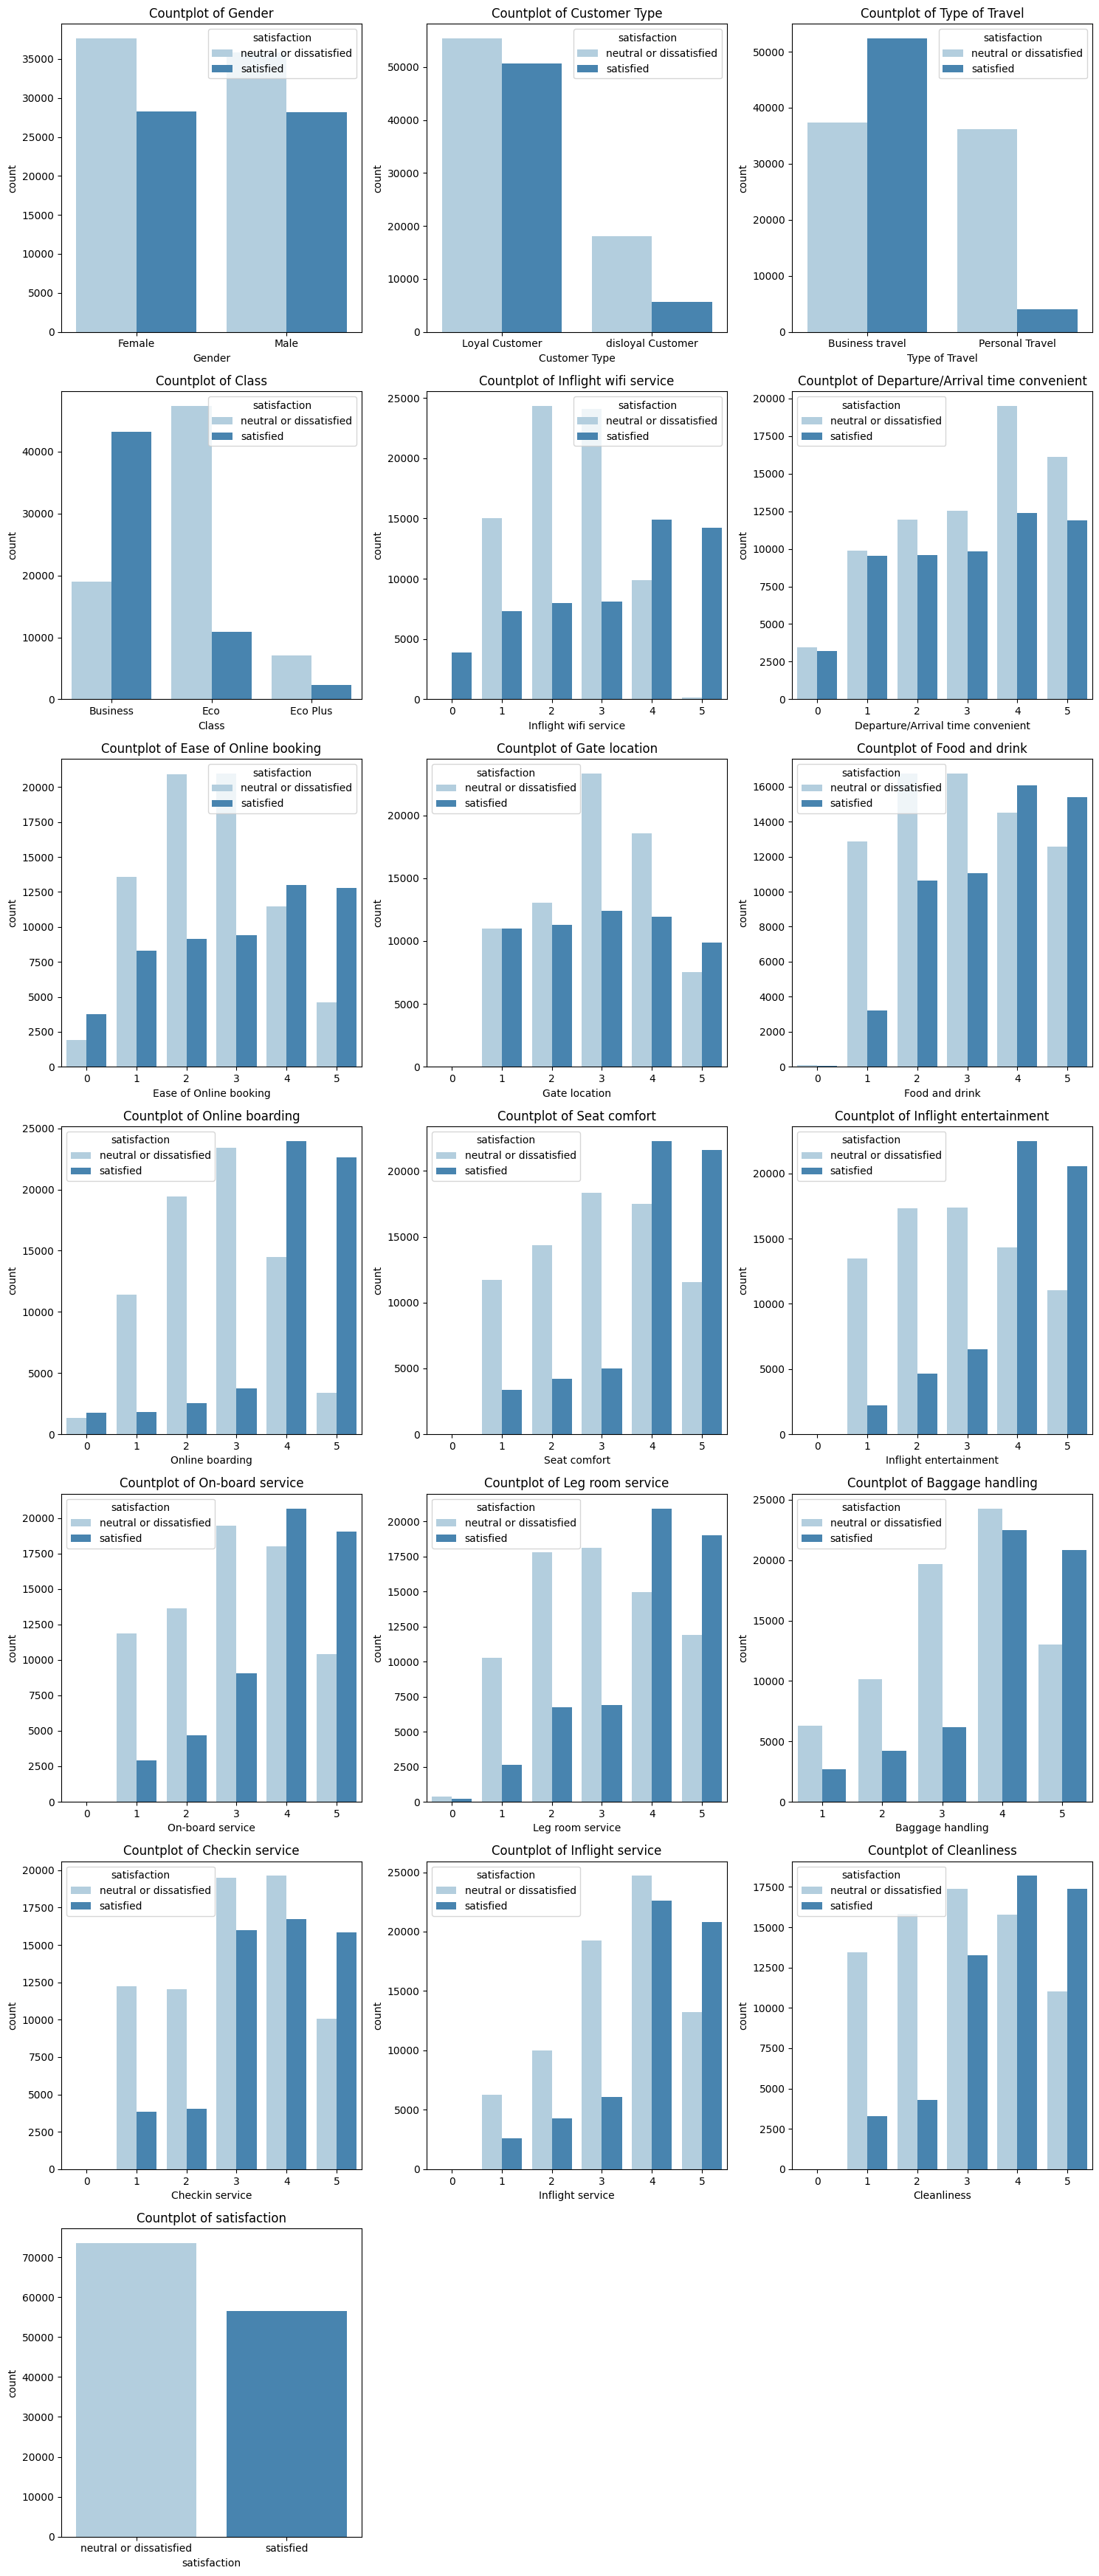

In [63]:
# List of categorical columns to plot (adjust according to your dataset)
categorical_columns = data.select_dtypes(include=['category']).columns

# Set up the number of subplots (rows and columns)
n_cols = 3  # Number of countplots per row (adjust as needed)
n_rows = (len(categorical_columns) // n_cols) + 1  # Number of rows for subplots

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes array for easy iteration if there are multiple rows and columns
axes = axes.flatten()

# Loop over each categorical column and create a countplot
for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, hue='satisfaction', palette='Blues', data=data, ax=axes[i])
    axes[i].set_title(f'Countplot of {col}')

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

<Axes: xlabel='Flight Distance', ylabel='Count'>

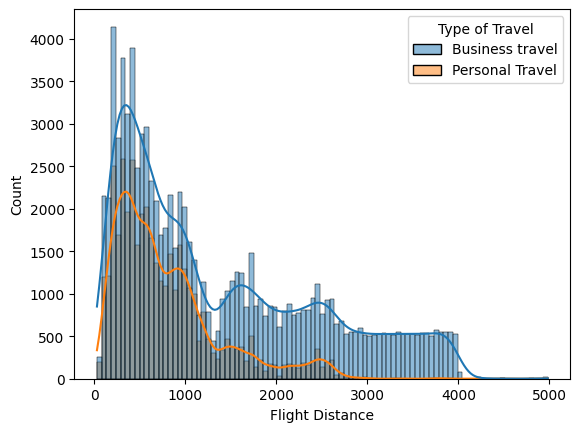

In [64]:
sns.histplot(data, x = "Flight Distance", kde=True, hue = "Type of Travel")
#flight distance, type of travel 

- most of the travel is buisness

<Axes: xlabel='Flight Distance', ylabel='Count'>

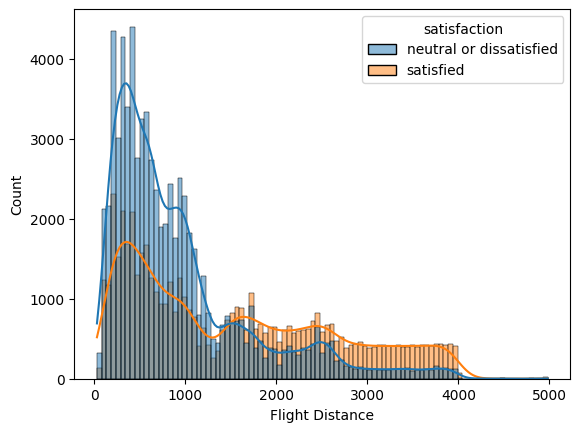

In [65]:


sns.histplot(data=data, x='Flight Distance', kde=True, hue='satisfaction')

## 2. Handeling missing values


In [66]:
data.isnull().sum()[data.isnull().sum()>0]

Arrival Delay in Minutes    393
dtype: int64

In [67]:
data['Arrival Delay in Minutes'].fillna(0,inplace=True)

In [68]:
data.isnull().sum()[data.isnull().sum()>0]

Series([], dtype: int64)

## 3. Duplicates

In [69]:
# --- To see the actual duplicate rows:
duplicate_rows = data[data.duplicated()]
duplicate_rows

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction


## 4. Treating outliers

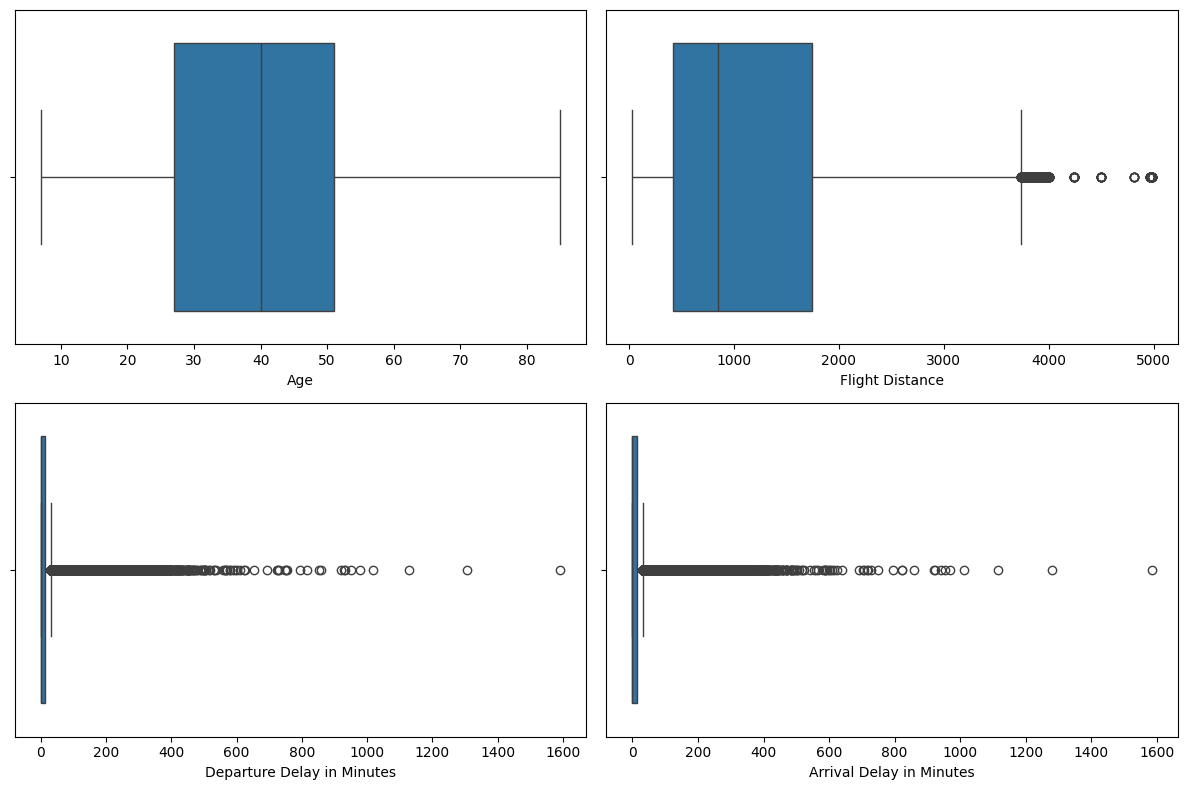

In [70]:
# Create a figure with 2 rows and 2 columns (4 plots)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot each boxplot on a different axis
sns.boxplot(ax=axs[0, 0], data=data, x='Age')
sns.boxplot(ax=axs[0, 1], data=data, x='Flight Distance')
sns.boxplot(ax=axs[1, 0], data=data, x='Departure Delay in Minutes')
sns.boxplot(ax=axs[1, 1], data=data, x='Arrival Delay in Minutes')

# Adjust layout
plt.tight_layout()
plt.show()

- Age does not have outliers
- it is to be expected that Depature and Arrival delay have that many outliers, so we will do nothing about it
- Flight distance has some outliers, so we will remove them

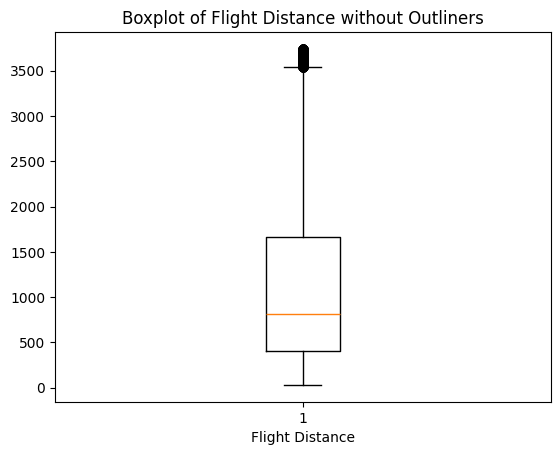

In [71]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['Flight Distance'].quantile(0.25)
Q3 = data['Flight Distance'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data = data[(data['Flight Distance'] >= lower_bound) & (data['Flight Distance'] <= upper_bound)]

plt.boxplot(data['Flight Distance'])

plt.title('Boxplot of Flight Distance without Outliners')
plt.xlabel('Flight Distance')
plt.show()

## 5. Scaling the data

In [72]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()

# Select only the numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Apply standardization to the numerical columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Display the scaled data
print(data[numerical_cols])

             Age  Flight Distance  Departure Delay in Minutes  \
0       0.834732        -1.052212                    0.928394   
1      -0.220042         1.880977                   -0.386348   
2      -1.274816        -1.017487                   -0.386348   
3       0.307345         2.438749                   -0.386348   
4       0.636962         0.056822                   -0.386348   
...          ...              ...                         ...   
129875 -1.077046        -1.017487                   -0.307464   
129876  0.636962         1.321034                   -0.386348   
129877 -0.615582         0.939057                   -0.202284   
129878 -1.142969        -0.140677                   -0.386348   
129879 -0.813352         0.643894                   -0.386348   

        Arrival Delay in Minutes  
0                       0.754532  
1                      -0.391619  
2                      -0.391619  
3                      -0.235326  
4                       0.129359  
...      

## 6. Encode labels

We have the following columns with their respective categories to label:

In [73]:
to_encode_columns=['Gender','Customer Type', 'Type of Travel', 'Class', 'satisfaction']

for column in to_encode_columns:
    categories = ', '.join(data[column].cat.categories)  # Get categories as a string
    print(f"{column}: {' ' * (20 - len(column))} {categories}")

Gender:                Female, Male
Customer Type:         Loyal Customer, disloyal Customer
Type of Travel:        Business travel, Personal Travel
Class:                 Business, Eco, Eco Plus
satisfaction:          neutral or dissatisfied, satisfied


In [74]:
data_encoded=data.copy()
labelencoder=LabelEncoder()

mappings={}

for column in to_encode_columns:
    data_encoded[column]=labelencoder.fit_transform(data[column])
    label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
    label_mapping = {key: int(value) for key, value in label_mapping.items()}
    mappings[column] = label_mapping

# Print the mappings in a nice format
print("Label Mappings:")
for col, mapping in mappings.items():
    print(f"\n{col} Encoding:")
    mapping_df = pd.DataFrame(list(mapping.items()), columns=[col, 'Encoded Value'])
    print(mapping_df.to_string(index=False))
    

Label Mappings:

Gender Encoding:
Gender  Encoded Value
Female              0
  Male              1

Customer Type Encoding:
    Customer Type  Encoded Value
   Loyal Customer              0
disloyal Customer              1

Type of Travel Encoding:
 Type of Travel  Encoded Value
Business travel              0
Personal Travel              1

Class Encoding:
   Class  Encoded Value
Business              0
     Eco              1
Eco Plus              2

satisfaction Encoding:
           satisfaction  Encoded Value
neutral or dissatisfied              0
              satisfied              1


In [75]:
data_encoded.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,0,0.834732,0,1,-1.052212,5,4,3,4,...,5,5,5,5,2,5,5,0.928394,0.754532,1
1,0,0,-0.220042,0,0,1.880977,1,1,3,1,...,4,4,4,4,3,4,5,-0.386348,-0.391619,1
2,1,1,-1.274816,0,1,-1.017487,2,0,2,4,...,2,4,1,3,2,2,2,-0.386348,-0.391619,0
3,1,0,0.307345,0,0,2.438749,0,0,0,2,...,1,1,1,1,3,1,4,-0.386348,-0.235326,1
4,0,0,0.636962,0,1,0.056822,2,3,4,3,...,2,2,2,2,4,2,4,-0.386348,0.129359,1


## 7. Feature selection

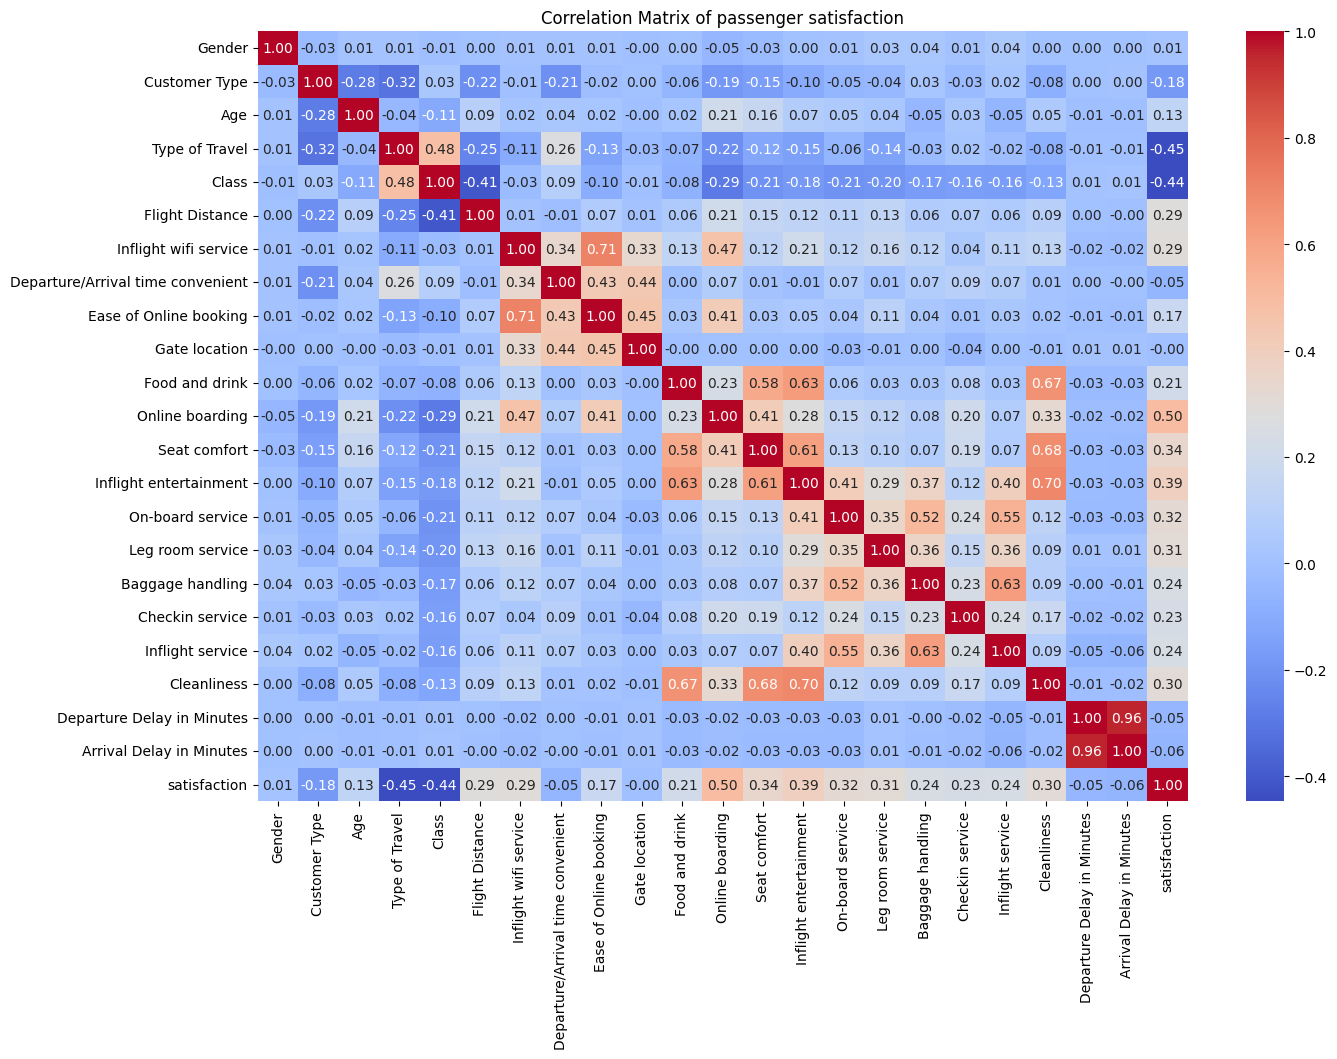

In [76]:
correlations = data_encoded.corr()

plt.figure(figsize=(15, 10))

sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix of passenger satisfaction')

plt.show()

In [77]:
# Compute the correlation matrix
corr_matrix = data_encoded.corr()

# Get the correlation values of all columns with respect to 'satisfaction'
satisfaction_corr = corr_matrix['satisfaction']

# Filter columns with correlation less than 0.1 (absolute value)
low_corr_columns = satisfaction_corr[satisfaction_corr.abs() < 0.1].index.tolist()
print(low_corr_columns)
#after trial and evaluating performance, this seems to be the best choice of set of columns
low_corr_columns = ['Gender', 'Departure/Arrival time convenient',  'Arrival Delay in Minutes']

data_encoded.drop(low_corr_columns,axis=1,inplace=True)

['Gender', 'Departure/Arrival time convenient', 'Gate location', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


In [78]:
data_encoded.head()

,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,0,0.834732,0,1,-1.052212,5,3,4,3,4,3,5,5,5,5,2,5,5,0.928394,1
1,0,-0.220042,0,0,1.880977,1,3,1,5,4,5,4,4,4,4,3,4,5,-0.386348,1
2,1,-1.274816,0,1,-1.017487,2,2,4,2,2,2,2,4,1,3,2,2,2,-0.386348,0
3,0,0.307345,0,0,2.438749,0,0,2,3,4,4,1,1,1,1,3,1,4,-0.386348,1
4,0,0.636962,0,1,0.056822,2,4,3,4,1,2,2,2,2,2,4,2,4,-0.386348,1


## Creating X and Y

In [79]:
# Retain all features for the model
X = data_encoded.drop('satisfaction', axis=1)
y = data_encoded['satisfaction']


### Splitting the Dataset

Split the preprocessed dataset into training, validation, and testing sets to evaluate model performance effectively.



Class Distribution Before Resampling:
 satisfaction
0    72783
1    54242
Name: count, dtype: int64


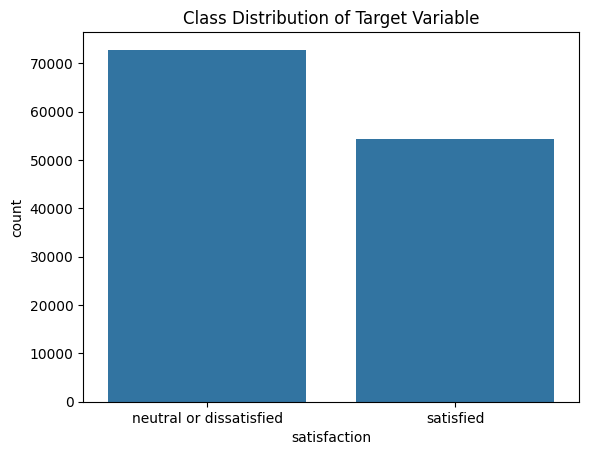

In [80]:
# Check class distribution
class_counts = y.value_counts()
print("\nClass Distribution Before Resampling:\n", class_counts)

# Plot class distribution
sns.countplot(x='satisfaction', data=data)
plt.title('Class Distribution of Target Variable')
plt.show()


From the correlation matrix, select features that have a higher correlation with the target variable `satisfaction`. Adjust the threshold as needed.


In [81]:
# Proceed without resampling to avoid potential overfitting
X_scaled = scaler.fit_transform(X)
y_resampled = y  # No resampling applied

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_resampled),
    y=y_resampled
)

# Convert to a dictionary for PyTorch
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [82]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f'Training set size: {X_train.shape[0]} samples')
print(f'Validation set size: {X_val.shape[0]} samples')
print(f'Test set size: {X_test.shape[0]} samples')


Training set size: 88917 samples
Validation set size: 19054 samples
Test set size: 19054 samples


## Logistic Regression Model with scikit-learn

Start by building a simple Logistic Regression model to predict passenger satisfaction.


Logistic Regression Test Accuracy: 86.90%
Precision: 0.8368
Recall: 0.8610
F1 Score: 0.8487
ROC AUC Score: 0.9264
Confusion Matrix:
[[9552 1366]
 [1131 7005]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

Dissatisfied       0.89      0.87      0.88     10918
   Satisfied       0.84      0.86      0.85      8136

    accuracy                           0.87     19054
   macro avg       0.87      0.87      0.87     19054
weighted avg       0.87      0.87      0.87     19054



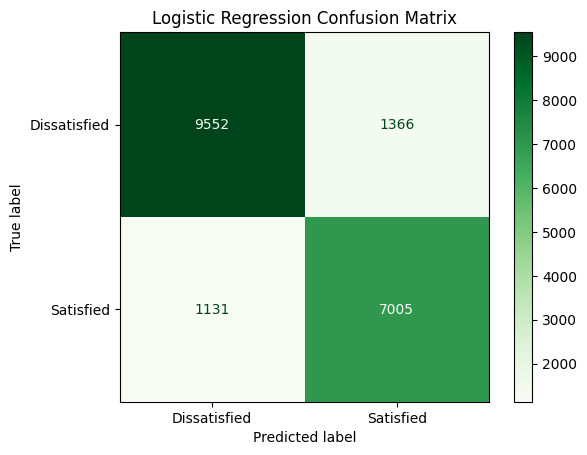

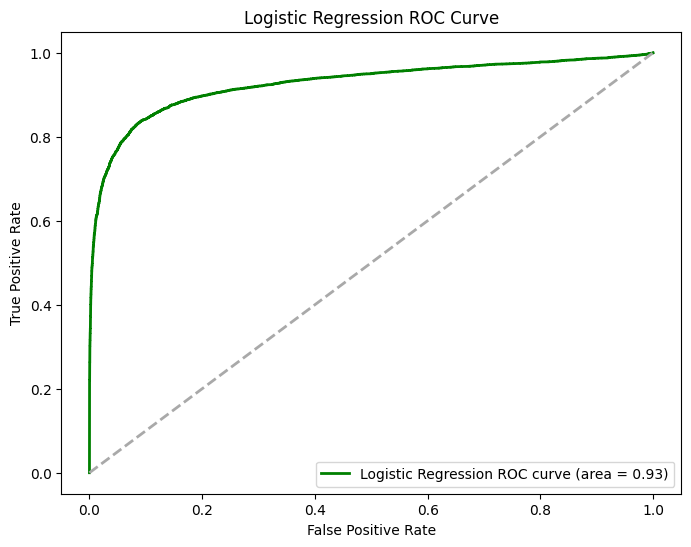

In [83]:
# Using Logistic Regression for Binary Classification
from sklearn.linear_model import LogisticRegression

# Initialize the model
log_reg = LogisticRegression(random_state=42, class_weight='balanced')

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_log = log_reg.predict(X_test)

# Evaluate the model
accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
roc_auc_log = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1])
cm_log = confusion_matrix(y_test, y_pred_log)

print(f"Logistic Regression Test Accuracy: {accuracy_log*100:.2f}%")
print(f"Precision: {precision_log:.4f}")
print(f"Recall: {recall_log:.4f}")
print(f"F1 Score: {f1_log:.4f}")
print(f"ROC AUC Score: {roc_auc_log:.4f}")
print("Confusion Matrix:")
print(cm_log)

# Classification Report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log, target_names=['Dissatisfied', 'Satisfied']))

# Plot Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=['Dissatisfied', 'Satisfied'])
disp_log.plot(cmap='Greens')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
roc_auc_log = auc(fpr_log, tpr_log)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, color='green', lw=2, label=f'Logistic Regression ROC curve (area = {roc_auc_log:.2f})')
plt.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Neural Network Model with PyTorch

Neural Network using PyTorch to predict passenger satisfaction.


In [84]:
# Define a custom Dataset
class SatisfactionDataset(Dataset):
    def __init__(self, features, targets):
        self.X = torch.tensor(features, dtype=torch.float32)
        # Convert targets to numpy array and reshape
        self.y = torch.tensor(targets.values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset objects
train_dataset = SatisfactionDataset(X_train, y_train)
val_dataset = SatisfactionDataset(X_val, y_val)
test_dataset = SatisfactionDataset(X_test, y_test)

# Define DataLoaders
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)


In [85]:
# Define the Enhanced Neural Network architecture
class EnhancedNeuralNet(nn.Module):
    def __init__(self, input_size):
        super(EnhancedNeuralNet, self).__init__()
        self.layers = nn.Sequential(
            # Input Layer
            nn.Linear(input_size, input_size),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(input_size),

            # First Hidden Layer
            nn.Linear(input_size, 16),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(16),
            nn.Dropout(0.2),

            # Second Hidden Layer
            nn.Linear(16, 32),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(32),
            nn.Dropout(0.5),

            # Third Hidden Layer
            nn.Linear(32, 16),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(16),

            # Fourth Hidden Layer
            nn.Linear(16, 32),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            # Fifth Hidden Layer
            nn.Linear(32, 16),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(16),

            # Output Layer
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
BATCH_SIZE = 256
EPOCHS = 150
LEARNING_RATE = 0.002

# DataLoader setup
train_dataset = SatisfactionDataset(X_train, y_train)
test_dataset = SatisfactionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model initialization
model = EnhancedNeuralNet(input_size=X_train.shape[1]).to(device)

# Convert class weights to tensor and move to device
class_weights_tensor = torch.tensor([class_weights_dict[0], class_weights_dict[1]], dtype=torch.float32).to(device)

# Use class weights in the loss function
pos_weight = torch.tensor(class_weights_dict[1] / class_weights_dict[0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)


### Early Stopping
Incorporate early stopping to prevent overfitting by halting training when validation loss ceases to improve.


In [86]:
# Define Early Stopping class
class EarlyStopping:
    def __init__(self, patience=15, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize Early Stopping
early_stopping = EarlyStopping(patience=100, delta=0.001)

### Training the Neural Network

Train the Neural Network for a specified number of epochs.


Epoch [1/150], Train Loss: 0.3249, Train Acc: 88.42%, Val Loss: 0.1882, Val Acc: 92.98%
Epoch [10/150], Train Loss: 0.1416, Train Acc: 95.03%, Val Loss: 0.1215, Val Acc: 95.63%
Epoch [20/150], Train Loss: 0.1308, Train Acc: 95.34%, Val Loss: 0.1145, Val Acc: 95.96%
Epoch [30/150], Train Loss: 0.1267, Train Acc: 95.48%, Val Loss: 0.1280, Val Acc: 95.33%
Epoch [40/150], Train Loss: 0.1216, Train Acc: 95.65%, Val Loss: 0.1104, Val Acc: 96.16%
Epoch [50/150], Train Loss: 0.1157, Train Acc: 95.85%, Val Loss: 0.1078, Val Acc: 96.14%
Epoch [60/150], Train Loss: 0.1153, Train Acc: 95.89%, Val Loss: 0.1065, Val Acc: 96.18%
Epoch [70/150], Train Loss: 0.1155, Train Acc: 95.87%, Val Loss: 0.1074, Val Acc: 96.13%
Epoch [80/150], Train Loss: 0.1147, Train Acc: 95.88%, Val Loss: 0.1063, Val Acc: 96.20%
Epoch [90/150], Train Loss: 0.1136, Train Acc: 95.90%, Val Loss: 0.1063, Val Acc: 96.14%
Epoch [100/150], Train Loss: 0.1140, Train Acc: 95.93%, Val Loss: 0.1061, Val Acc: 96.20%
Epoch [110/150], Trai

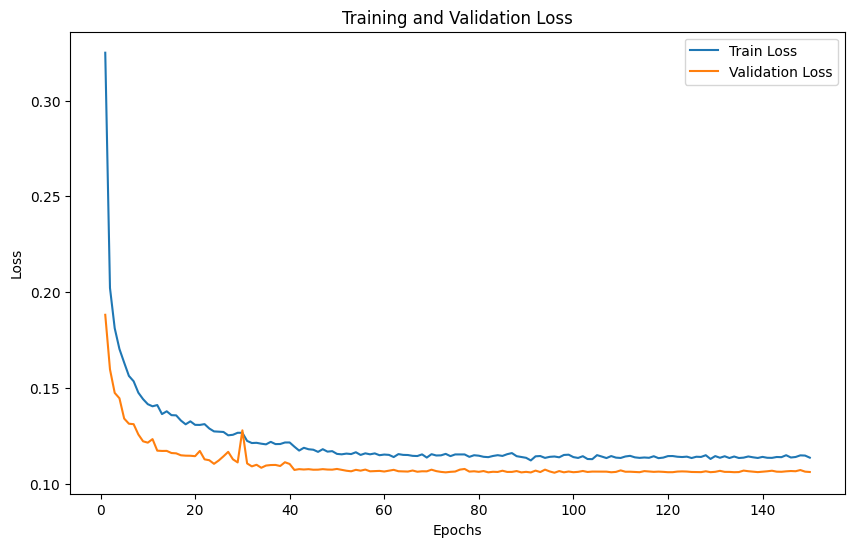

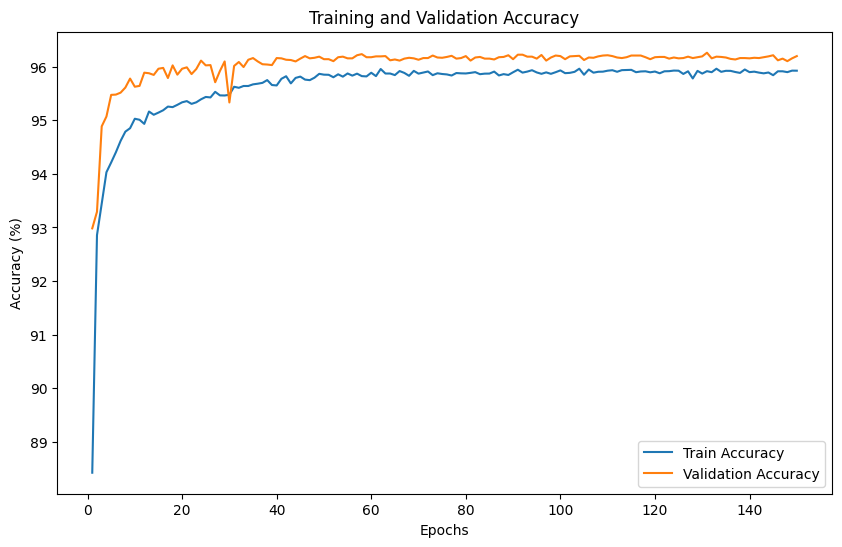

In [87]:
# Initialize lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define Early Stopping object
early_stopping = EarlyStopping(patience=100, delta=0.001)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)
        # Calculate accuracy
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        correct += (preds.cpu() == batch_y.cpu()).sum().item()
        total += batch_y.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_running_loss += loss.item() * batch_X.size(0)
            # Calculate accuracy
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            val_correct += (preds.cpu() == batch_y.cpu()).sum().item()
            val_total += batch_y.size(0)
    epoch_loss_val = val_running_loss / val_total
    epoch_acc_val = val_correct / val_total
    val_losses.append(epoch_loss_val)
    val_accuracies.append(epoch_acc_val)

    # Learning rate scheduling
    scheduler.step(epoch_loss_val)

    # Early Stopping Check
    early_stopping(epoch_loss_val)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    # Logging
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc*100:.2f}%, '
              f'Val Loss: {epoch_loss_val:.4f}, Val Acc: {epoch_acc_val*100:.2f}%')

# Plot Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_accuracies)+1), [acc*100 for acc in train_accuracies], label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), [acc*100 for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Evaluating the Neural Network

Let's predict the satisfaction scores on the test set and evaluate the model's performance.


Neural Network Test Accuracy: 96.24%
Precision: 0.9673
Recall: 0.9438
F1 Score: 0.9554
ROC AUC Score: 0.9943
Confusion Matrix:
[[10658   260]
 [  457  7679]]

Classification Report:
              precision    recall  f1-score   support

Dissatisfied       0.96      0.98      0.97     10918
   Satisfied       0.97      0.94      0.96      8136

    accuracy                           0.96     19054
   macro avg       0.96      0.96      0.96     19054
weighted avg       0.96      0.96      0.96     19054



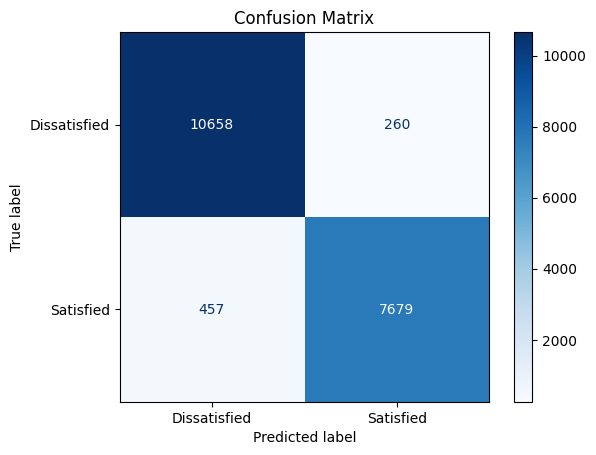

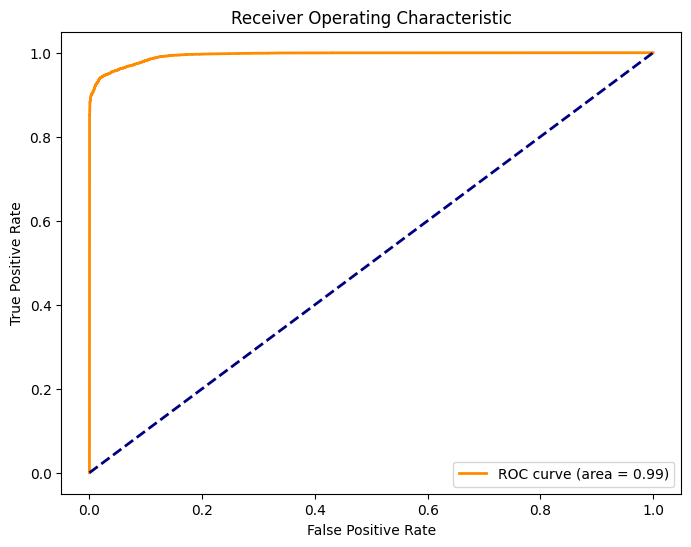

In [88]:
# Evaluation Metrics Function
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    return np.array(all_preds).flatten(), np.array(all_labels).flatten(), np.array(all_probs).flatten()

# Get predictions and probabilities
y_pred_nn, y_actual_nn, y_prob_nn = evaluate_model(model, test_loader)

# Calculate Metrics
accuracy = accuracy_score(y_actual_nn, y_pred_nn)
precision = precision_score(y_actual_nn, y_pred_nn)
recall = recall_score(y_actual_nn, y_pred_nn)
f1 = f1_score(y_actual_nn, y_pred_nn)
roc_auc = roc_auc_score(y_actual_nn, y_prob_nn)
cm = confusion_matrix(y_actual_nn, y_pred_nn)

print(f"Neural Network Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_actual_nn, y_pred_nn, target_names=['Dissatisfied', 'Satisfied']))

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dissatisfied', 'Satisfied'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_actual_nn, y_prob_nn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Plotting Actual vs Predicted Values

Visualizing the performance of the Neural Network model.


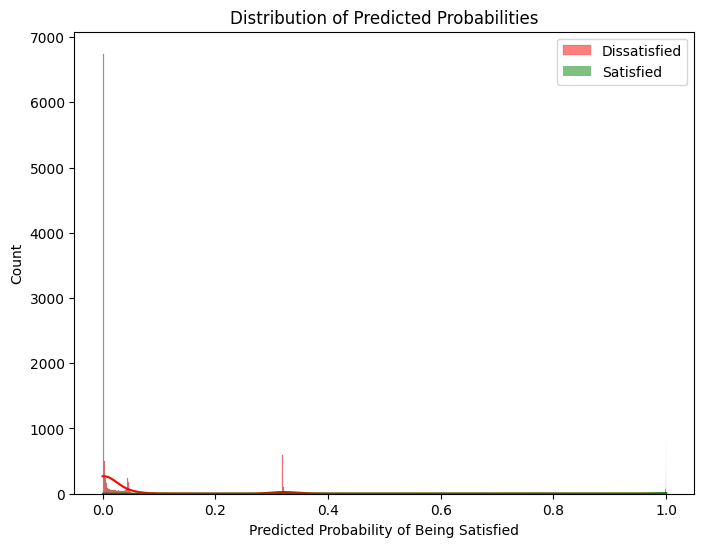

In [89]:
# Plotting the Distribution of Predicted Probabilities
plt.figure(figsize=(8,6))
sns.histplot(y_prob_nn[y_actual_nn == 0], color='red', label='Dissatisfied', kde=True)
sns.histplot(y_prob_nn[y_actual_nn == 1], color='green', label='Satisfied', kde=True)
plt.xlabel('Predicted Probability of Being Satisfied')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()


## Comparing the Models

Compare the performance metrics of both models.


In [90]:
# Create a DataFrame for comparison
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Neural Network'],
    'Accuracy (%)': [accuracy_log*100, accuracy*100],
    'Precision': [precision_log, precision],
    'Recall': [recall_log, recall],
    'F1 Score': [f1_log, f1],
    'ROC AUC': [roc_auc_log, roc_auc]
})

print(comparison)


                 Model  Accuracy (%)  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression     86.895140   0.836818  0.860988  0.848731  0.926442
1       Neural Network     96.237011   0.967250  0.943830  0.955397  0.994295
